In [1]:
import numpy as np
from scipy import signal
import scipy.stats
import matplotlib.pyplot as plt

def get_gdf_kernel(sigma, n_sigma=3):
    """
    Returns normalized Gaussian Derivative to be used as the GDF kernel.
    :param sigma: width of the Gaussian in time samples
    :param n_sigma: number of sigmas to include in the kernel
    :return: GDF kernel as a np.array
    """
    x = np.arange(-sigma * n_sigma, sigma * n_sigma + 1)
    gaus = scipy.stats.norm(scale=sigma).pdf(x)
    kernel = np.diff(gaus)
    step_function = -np.heaviside(x[:-1], 1)
    return kernel / np.dot(kernel, step_function)

def threshold_trigger_1d(raw_record, kernel, trigger_threshold=100, deactivation_threshold_coefficient=1, trigger_holdoff=0):
    """
    Fast threshold trigger with convolution for a single trace.
    Assumes a simple threshold crossing (with optional holdoff).
    """
    filtered = signal.convolve(raw_record, kernel, mode='valid')
    deactivate_threshold = trigger_threshold * deactivation_threshold_coefficient

    triggered = False
    hits = []
    i = 0
    while i < len(filtered):
        if not triggered and filtered[i] > trigger_threshold:
            hits.append(i)
            triggered = True
            i += trigger_holdoff  # fast skip
        elif triggered and filtered[i] < deactivate_threshold:
            triggered = False
        i += 1

    return filtered, hits

def threshold_trigger_2d(records, sigma, trigger_threshold=100, deactivation_threshold_coefficient=1, trigger_holdoff=0, n_sigma=3):
    """
    Optimized batch threshold trigger for multiple records with configurable sigma.
    Generates the GDF kernel internally using sigma.

    :param records: 2D array of traces (n_records, n_samples)
    :param sigma: Gaussian sigma used for GDF kernel
    :param trigger_threshold: Threshold for triggering
    :param deactivation_threshold_coefficient: Coefficient for deactivation threshold
    :param trigger_holdoff: Number of samples to hold off after trigger
    :param n_sigma: Number of sigmas to include in the kernel
    :return: (filtered_records, all_hits, total_hits)
    """
    kernel = get_gdf_kernel(sigma, n_sigma)
    num_records = len(records)
    filtered_records = np.empty(num_records, dtype=object)
    all_hits = []

    kernel_len = len(kernel)
    conv_len = records.shape[1] - kernel_len + 1

    for i in range(num_records):
        raw = records[i]
        filtered = signal.convolve(raw, kernel, mode='valid')
        filtered_records[i] = filtered

        deactivate_threshold = trigger_threshold * deactivation_threshold_coefficient
        hits = []
        triggered = False
        j = 0
        while j < conv_len:
            if not triggered and filtered[j] > trigger_threshold:
                hits.append(j)
                triggered = True
                j += trigger_holdoff
            elif triggered and filtered[j] < deactivate_threshold:
                triggered = False
            j += 1

        all_hits.append(hits)

    total_hits = sum(len(h) for h in all_hits)
    return filtered_records, all_hits, total_hits


In [2]:
import yaml
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('config.yaml')
ts = TraceSimulator(config)

/home/dwong/anaconda3/lib/python3.12/site-packages/TraceSimulator/TraceSimulator.py:185: RuntimeWarning: overflow encountered in exp
  self.template = np.concatenate([(np.exp((xs - self.trigger_time) / self.tau_rise))[xs <= self.trigger_time], (np.exp(-(xs - self.trigger_time) / self.tau_decay))[xs > self.trigger_time]])


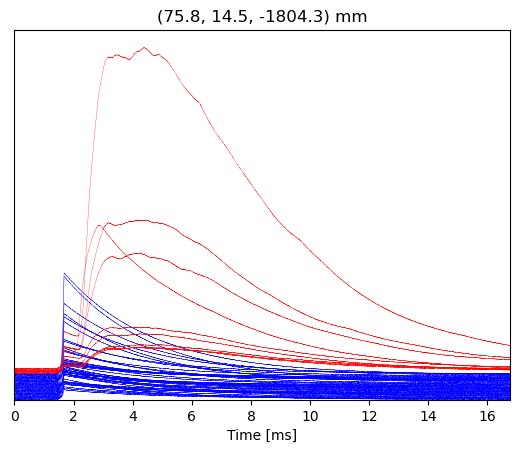

In [4]:
trace, (x, y, z) = ts.generate(5e5, type_recoil='NR') # generate a 20 keV ER from a random position in the volume
times = 0.5 * (ts.t_edges[1:] + ts.t_edges[:-1])
for i in range(54):
    if i > 44:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='r', lw=0.2)
    else:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='b', lw=0.2)
        
plt.xlim(0, np.max(times * 1e-6)), plt.xlabel('Time [ms]')
plt.ylim(-10), plt.yticks([])
plt.title(f'({x[0]:.1f}, {y[0]:.1f}, {z[0]:.1f}) mm');

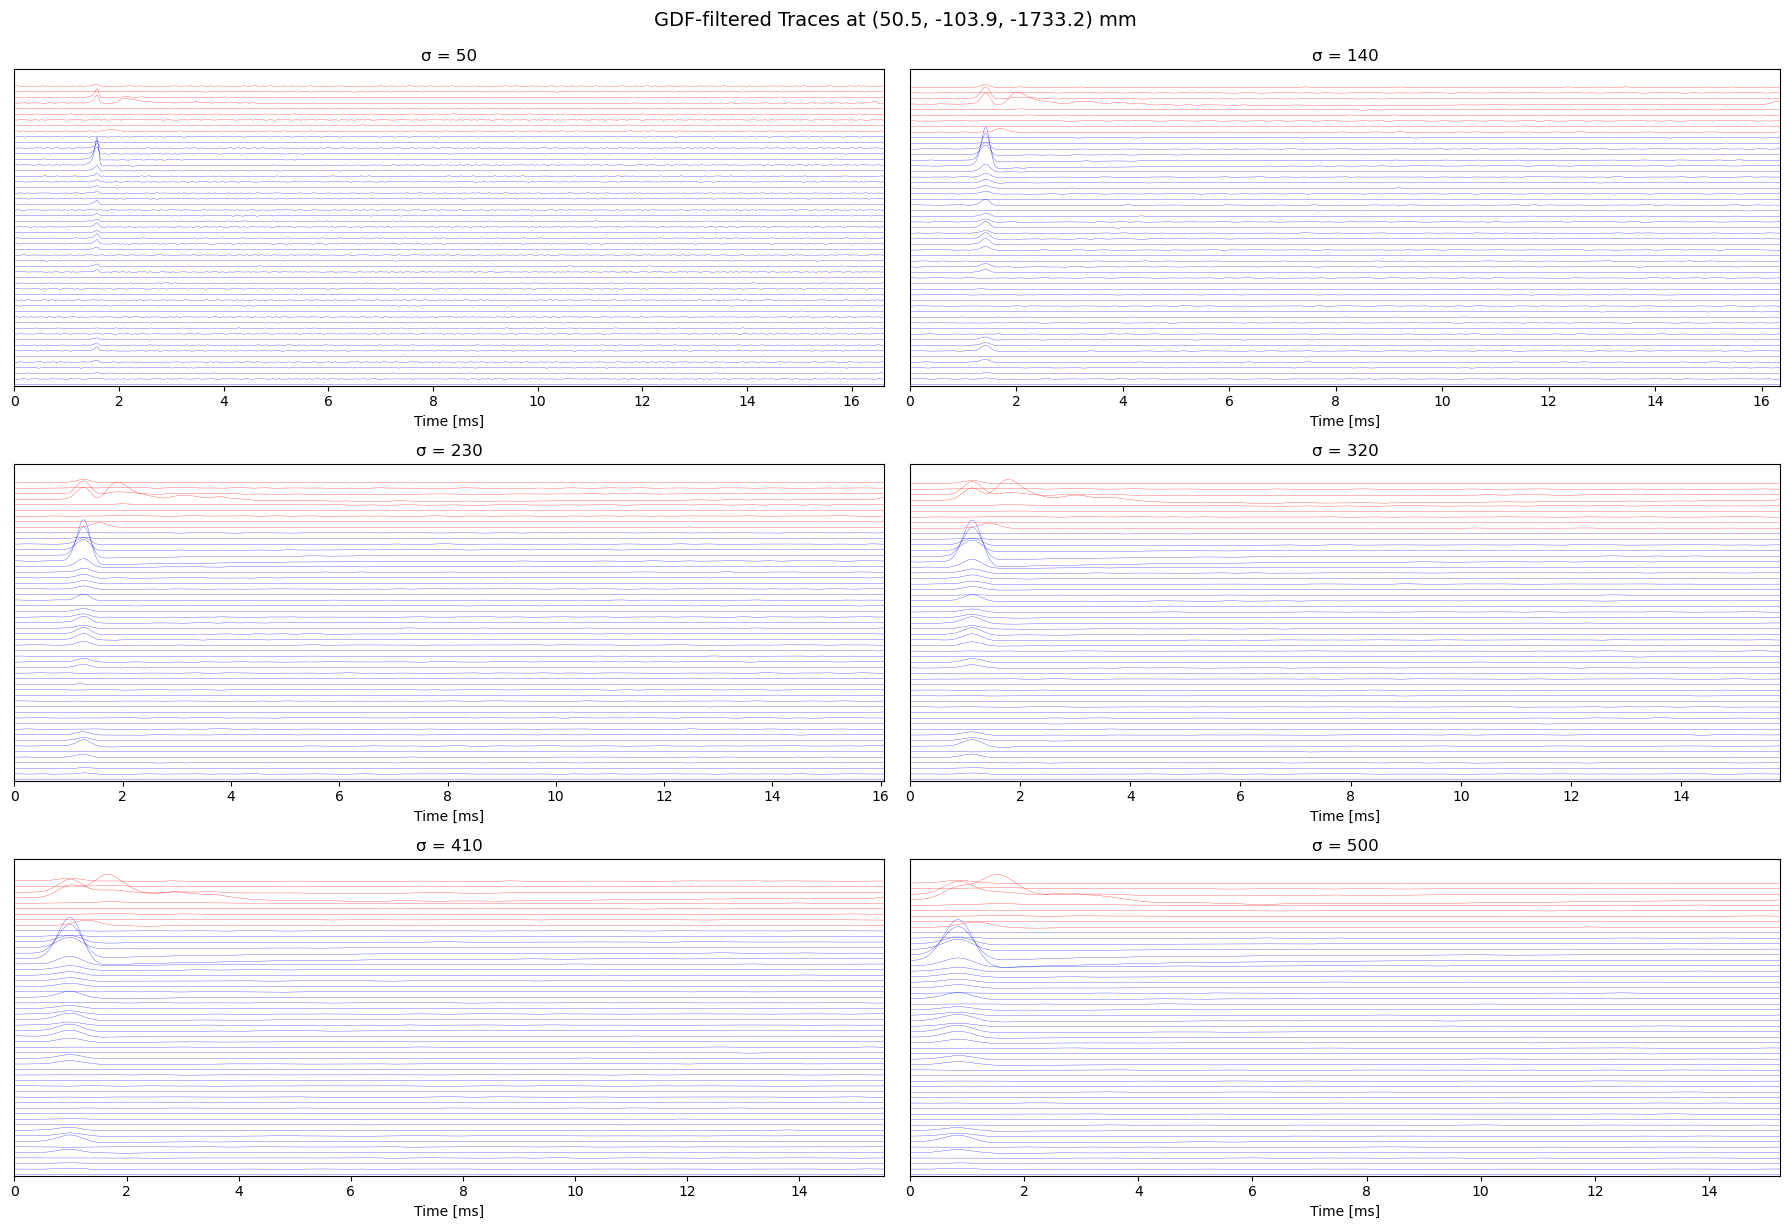

In [9]:
sigmas = [50, 140, 230, 320, 410, 500]  # six sigma values

plt.figure(figsize=(18, 12))

for idx, sigma in enumerate(sigmas):
    kernel = get_gdf_kernel(sigma)
    kernel_len = len(kernel)
    
    # Apply GDF to each trace
    filtered_traces = [signal.convolve(trace[0][i], kernel, mode='valid') for i in range(54)]
    times_gdf = times[:len(times) - kernel_len + 1]

    # Plot
    plt.subplot(3, 2, idx + 1)
    for i in range(54):
        color = 'r' if i > 44 else 'b'
        plt.plot(times_gdf * 1e-6, filtered_traces[i] + i * 50, c=color, lw=0.2)

    plt.xlim(0, np.max(times_gdf * 1e-6))
    plt.ylim(-10)
    plt.yticks([])
    plt.xlabel('Time [ms]')
    plt.title(f'σ = {sigma}')

plt.tight_layout()
plt.suptitle(f'GDF-filtered Traces at ({x[0]:.1f}, {y[0]:.1f}, {z[0]:.1f}) mm', fontsize=14, y=1.02)
plt.show()


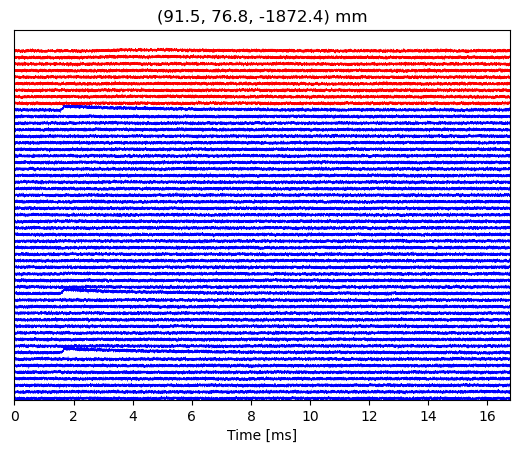

In [3]:
trace, (x, y, z) = ts.generate(200, type_recoil='NR') # generate a 20 keV ER from a random position in the volume
times = 0.5 * (ts.t_edges[1:] + ts.t_edges[:-1])
for i in range(54):
    if i > 44:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='r', lw=0.2)
    else:
        plt.plot(times * 1e-6, trace[0][i] + i * 50, c='b', lw=0.2)
        
plt.xlim(0, np.max(times * 1e-6)), plt.xlabel('Time [ms]')
plt.ylim(-10), plt.yticks([])
plt.title(f'({x[0]:.1f}, {y[0]:.1f}, {z[0]:.1f}) mm');

In [13]:
import numpy as np
from numpy.fft import fft, ifft

class MatchedFilter:
    def __init__(self, template_path, noise_psd_path, sampling_frequency):
        # Load template and PSD from .npy files
        self._template = np.load(template_path)
        self._noise_psd = np.load(noise_psd_path)
        self._sampling_frequency = sampling_frequency
        self._update_state()

    def set_template(self, template):
        self._template = template
        self._update_state()

    def set_noise_psd(self, noise_psd):
        self._noise_psd = noise_psd
        self._update_state()

    def _update_state(self):
        self._length = len(self._template)

        if self._length % 2 == 0:
            self._noise_psd_unfolded = np.concatenate((
                [np.inf],
                self._noise_psd[1:-1] / 2,
                [self._noise_psd[-1]],
                self._noise_psd[-2:0:-1] / 2
            ))
        else:
            self._noise_psd_unfolded = np.concatenate((
                [np.inf],
                self._noise_psd[1:] / 2,
                self._noise_psd[-1:0:-1] / 2
            ))

        self._template_fft = fft(self._template) / self._sampling_frequency
        self._kernel_fft = self._template_fft.conjugate() / self._noise_psd_unfolded
        self._kernel_normalization = np.real(np.dot(
            self._kernel_fft, self._template_fft
        )) * self._sampling_frequency / self._length

    def fit(self, trace):
        # Perform FFT of the input trace
        trace_fft = fft(trace) / self._sampling_frequency

        # Matched filtering operation in frequency domain
        trace_filtered_fft = self._kernel_fft * trace_fft / self._kernel_normalization

        # Return the inverse FFT to get the filtered trace in time domain
        trace_filtered_time = np.real(ifft(trace_filtered_fft))

        return trace_filtered_time

    def denoise_trace(self, trace):
        # Build time-domain kernel: template / noise_psd_unfolded
        filter_fft = self._template_fft / self._noise_psd_unfolded
        kernel_time = np.real(ifft(filter_fft))

        # Convolve directly in time domain
        trace_denoised = np.convolve(trace, kernel_time, mode='same')

        return trace_denoised


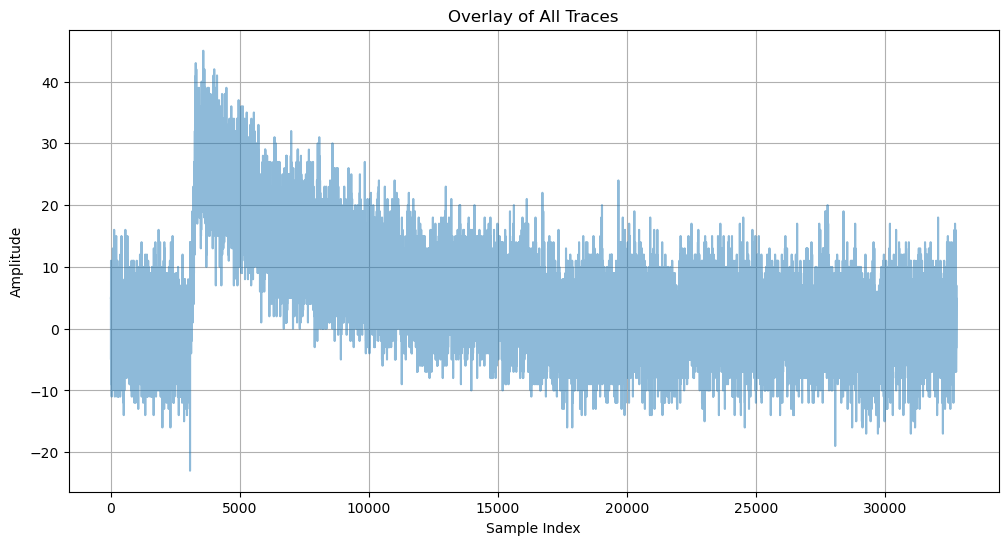

In [8]:
# Plot 1: Overlay of all traces
plt.figure(figsize=(12, 6))
plt.plot(trace[0][44], alpha=0.5)
plt.title('Overlay of All Traces')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


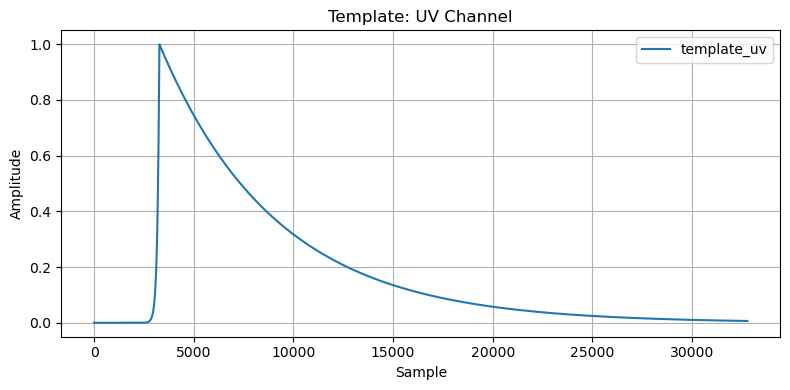

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load template
template_path = "../templates/template_uv.npy"
template = np.load(template_path)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(template, label="template_uv")
plt.title("Template: UV Channel")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


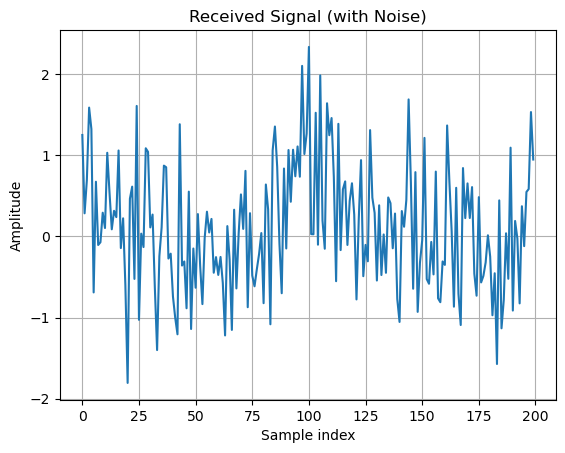

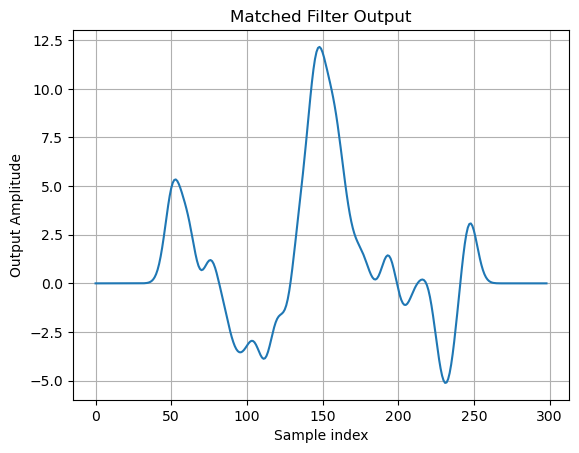

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1) Define a known signal s(t)
# -------------------------------------------------------------
# For example, let's create a simple "chirp-like" or "pulse" signal.
# Time axis: we'll work with discrete samples for t = 0, 1, ..., N-1

N = 100  # total number of samples for the signal
t = np.arange(N)

# Example: a simple Gaussian pulse or something similar
s = np.exp(-0.5 * ((t - (N/2)) / 5.0)**2)

# -------------------------------------------------------------
# 2) Create a received signal x(t) = s(t) + noise
# -------------------------------------------------------------
# We'll embed 's(t)' in a longer time series with leading/trailing zeros
# for demonstration.
L = 200  # length of the entire received signal
x = np.zeros(L)
noise_power = 0.5

# Place s(t) starting at index=50
start_idx = 50
x[start_idx : start_idx + N] = s

# Add additive white Gaussian noise
np.random.seed(0)  # for reproducibility
noise = np.sqrt(noise_power) * np.random.randn(L)
x_noisy = x + noise

# -------------------------------------------------------------
# 3) Construct matched filter h(t) = reversed s(t)
# -------------------------------------------------------------
# Note: In discrete-time, "reverse" is s[n] -> s[N-1-n].
# We'll keep the same length as s(t). 
h = np.flip(s)

# -------------------------------------------------------------
# 4) Convolve x_noisy(t) with h(t) to get the matched filter output
# -------------------------------------------------------------
# We'll use 'full' mode to get the entire convolution.
y = np.convolve(x_noisy, h, mode='full')

# -------------------------------------------------------------
# 5) Plot or print the results
# -------------------------------------------------------------
# We'll create two distinct plots:
#   - First: the received signal + noise
#   - Second: the matched filter output
# (No subplots per instructions.)

# Plot the noisy received signal
plt.figure()
plt.title("Received Signal (with Noise)")
plt.plot(x_noisy)
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Plot the matched filter output
plt.figure()
plt.title("Matched Filter Output")
plt.plot(y)
plt.xlabel("Sample index")
plt.ylabel("Output Amplitude")
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# Observe the main peak in 'y' around where 's' begins
# (start_idx + (N - 1)) for discrete-time).
# -------------------------------------------------------------


In [ ]:
from numpy.fft import rfft, irfft, rfftfreq
import numpy as np
import matplotlib.pyplot as plt

# Load your data
traces = np.load('path_to_your_traces.npy')  # This might be 1D or 2D array
pulse_template = np.load('path_to_your_template.npy')  # This should be 1D array

# Define sampling frequency (adjust this to your actual sampling rate)
sampling_frequency = 1.0  # Hz

# Calculate noise PSD from your traces
def calculate_psd(traces, sampling_frequency=1.0):
    """Return the PSD of an n-dimensional array, assuming that we want the PSD of the last axis."""
    
    # calculate normalization for correct units
    norm = sampling_frequency * traces.shape[-1]

    # if folded_over = True, we calculate the Fourier Transform for only the positive frequencies
    if len(traces.shape)==1:
        psd = (np.abs(rfft(traces))**2.0)/norm
    else:
        psd = np.mean(np.abs(rfft(traces))**2.0, axis=0)/norm

    # multiply the necessary frequencies by two (zeroth frequency should be the same, as
    # should the last frequency when x.shape[-1] is odd)
    psd[1:traces.shape[-1]//2+1 - (traces.shape[-1]+1)%2] *= 2.0
    f = rfftfreq(traces.shape[-1], d=1.0/sampling_frequency)

    return f, psd

# Calculate the noise PSD
f, noise_psd = calculate_psd(traces, sampling_frequency)

# Implement matched filter 
def matched_filter_freq_domain(signal, template, noise_psd):
    """
    Implement a matched filter in frequency domain using one-sided PSD
    """
    # Get one-sided FFT of signal and template
    signal_fft = rfft(signal)
    template_fft = rfft(template)
    
    # Add small constant to avoid division by zero
    eps = np.median(noise_psd) * 1e-10
    safe_noise_psd = noise_psd + eps
    
    # Create matched filter (conjugate of template divided by noise PSD)
    matched_filter = np.conj(template_fft) / safe_noise_psd
    
    # Apply filter
    filtered_fft = signal_fft * matched_filter
    
    # Transform back to time domain
    filtered_signal = irfft(filtered_fft, n=len(signal))
    
    return filtered_signal

# Process each trace or a specific trace
if len(traces.shape) > 1:
    # If traces is a 2D array, process each trace individually
    filtered_traces = np.array([matched_filter_freq_domain(trace, pulse_template, noise_psd) 
                              for trace in traces])
else:
    # If traces is a 1D array, process it directly
    filtered_traces = matched_filter_freq_domain(traces, pulse_template, noise_psd)

# Optional: Visualize results
plt.figure(figsize=(12, 8))

# Plot an example of original and filtered trace
if len(traces.shape) > 1:
    example_idx = 0  # Index of example trace to plot
    plt.subplot(211)
    plt.plot(traces[example_idx])
    plt.title('Original Trace')
    
    plt.subplot(212)
    plt.plot(filtered_traces[example_idx])
    plt.title('Filtered Trace')
else:
    plt.subplot(211)
    plt.plot(traces)
    plt.title('Original Trace')
    
    plt.subplot(212)
    plt.plot(filtered_traces)
    plt.title('Filtered Trace')

plt.tight_layout()
plt.show()

# Save the filtered traces if needed
np.save('filtered_traces.npy', filtered_traces)